In [1]:
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")
source("/home/yuliya/repos/other/removeBatch/evaluation_utils/evaluation_funcs.R")

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Warning message:
“package ‘umap’ was built under R version 4.3.3”
Warning message:
“package ‘ggsci’ was built under R version 4.3.3”
Loading required package: viridisLite

Loading required package: limma

Warning message:
“package ‘limm

In [2]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Load data

In [3]:
data_path <- "../evaluation_data/microarray/"

central_uncorrected <- read.csv(paste0(data_path, "before/all_expression_UNION.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
metadata <- read.csv(paste0(data_path, "before/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

central_corrected <- read.csv(paste0(data_path, "after/central_corrected_UNION.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
fed_corrected <- read.csv(paste0(data_path, "after/FedSim_corrected_data.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)

# remove X from row names
rownames(metadata) <- gsub("X", "", rownames(metadata))
metadata$file <- rownames(metadata)
# order the columns in intensity dataframes

central_uncorrected <- central_uncorrected[, rownames(metadata)]

central_corrected <- central_corrected[rownames(central_uncorrected), rownames(metadata)]
fed_corrected <- fed_corrected[rownames(central_uncorrected), rownames(metadata)]

cat("Loaded data")
cat("Central corrected:", nrow(central_corrected), "rows\n")
cat("Central uncorrected:", nrow(central_uncorrected), "rows\n")
cat("Fed corrected:", nrow(fed_corrected), "rows\n")
cat("Sample metadata:", nrow(metadata), "rows\n\n")



Loaded dataCentral corrected: 51276 rows
Central uncorrected: 51276 rows
Fed corrected: 51276 rows
Sample metadata: 332 rows



# Checks

## Diagnostic plots

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


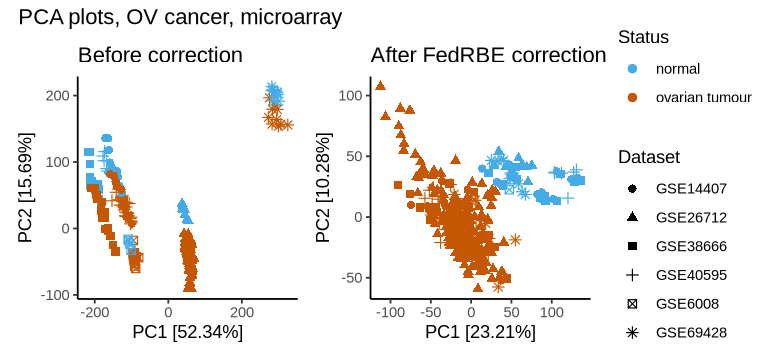

In [4]:
pca_plot_uncorrected <- pca_plot(central_uncorrected, metadata, 
    title = paste("Before correction"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=F, cbPalette=c("#44abe7", "#c55702"))

# pca_plot_corrected <- pca_plot(central_corrected, metadata, 
#     title = paste("After central correction"),
#     quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=F, cbPalette=c("#44abe7", "#c55702"))
pca_plot_fed <- pca_plot(fed_corrected, metadata, 
    title = paste("After FedRBE correction"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=T, cbPalette=c("#44abe7", "#c55702"))


layout <- (pca_plot_uncorrected + pca_plot_fed)
# add layout plot title
layout <- layout + plot_annotation("PCA plots, OV cancer, microarray")

options(repr.plot.width=6.5, repr.plot.height=3)
layout

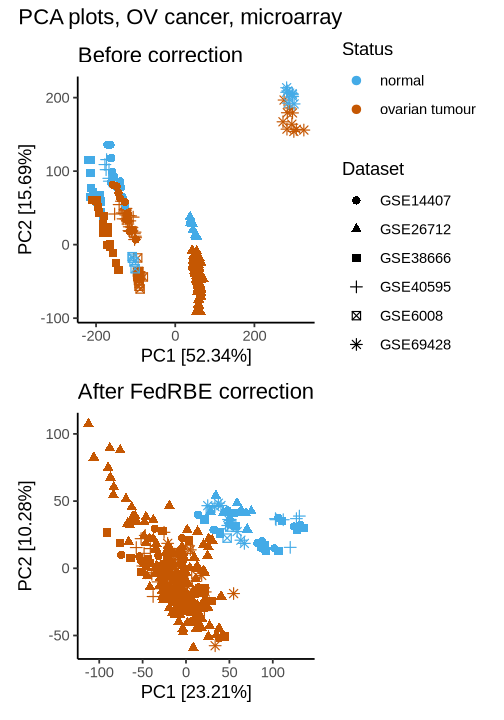

In [24]:
pca_plot_uncorrected <- pca_plot(central_uncorrected, metadata, 
    title = paste("Before correction"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=T, cbPalette=c("#44abe7", "#c55702"))
pca_plot_fed <- pca_plot(central_corrected, metadata, 
    title = paste("After FedRBE correction"),
    quantitative_col_name = "file", col_col= "Status", shape_col ="Dataset", show_legend=F, cbPalette=c("#44abe7", "#c55702"))



layout <- pca_plot_uncorrected / 
          pca_plot_fed
layout <- layout + plot_annotation("PCA plots, OV cancer, microarray")
options(repr.plot.width=4.2, repr.plot.height=6)
layout

Warning message:
“Removed 915306 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 915306 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 915306 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 913538 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 913538 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 913538 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_violin()`).”


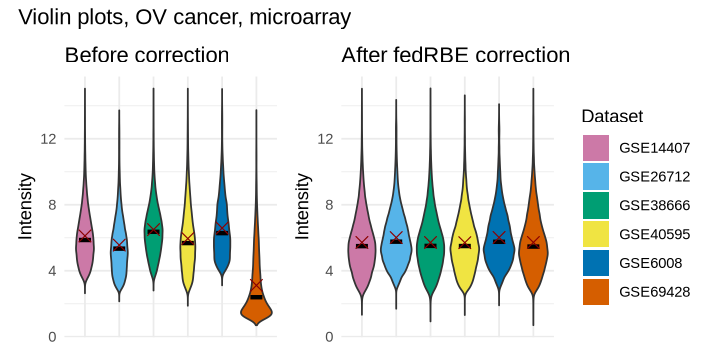

In [30]:
# sample 7000 rows for boxplots
sample_uncor <- central_uncorrected[sample(1:nrow(central_uncorrected), 7000),]
sample_cor <- central_corrected[sample(1:nrow(central_corrected), 7000),]
sample_fed <- fed_corrected[sample(1:nrow(fed_corrected), 7000),]

# # Determine the shared Y-axis limits
y_min <- min(sample_cor, min(sample_uncor, na.rm = TRUE), na.rm = TRUE)
y_max <- max(sample_cor, max(sample_uncor, na.rm = TRUE), na.rm = TRUE)
y_limits <- c(y_min, y_max)

boxplots_uncorrected <- boxplot_plot_groupped(sample_uncor, metadata,
    title = paste("Before correction"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
# boxplots_corrected <- boxplot_plot_groupped(sample_cor, metadata, 
#     title = paste("After central correction"),
#     quantitativeColumnName = "file",
#     color_col = "Dataset", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
boxplots_fed <- boxplot_plot_groupped(sample_fed, metadata,
    title = paste("After fedRBE correction"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, y_limits = y_limits, cbPalette = cbPalette)


options(repr.plot.width=6, repr.plot.height=3)
layout <- boxplots_uncorrected | boxplots_fed
layout <- layout + plot_annotation("Violin plots, OV cancer, microarray")
layout

Warning message:
“Removed 908424 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 908424 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 908424 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 42 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 903540 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 903540 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 903540 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 37 rows containing missing values or values outside the scale range
(`geom_violin()`).”


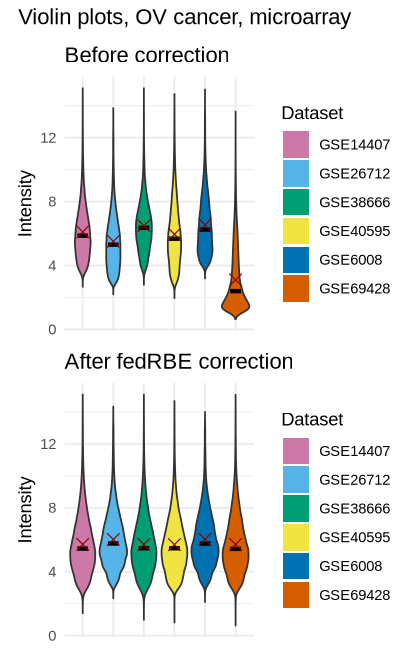

In [29]:
boxplots_uncorrected <- boxplot_plot_groupped(sample_uncor, metadata,
    title = paste("Before correction"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, show_legend=T, y_limits = y_limits, cbPalette = cbPalette)
boxplots_fed <- boxplot_plot_groupped(sample_fed, metadata,
    title = paste("After fedRBE correction"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T, show_legend=T, y_limits = y_limits, cbPalette = cbPalette)


options(repr.plot.width=3.5, repr.plot.height=5.5)
layout <- boxplots_uncorrected /
          boxplots_fed
layout <- layout + plot_annotation("Violin plots, OV cancer, microarray")
layout

##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [31]:
library(variancePartition)

In [32]:
# version of variancePartition package:
packageVersion("variancePartition")

[1] ‘1.32.2’

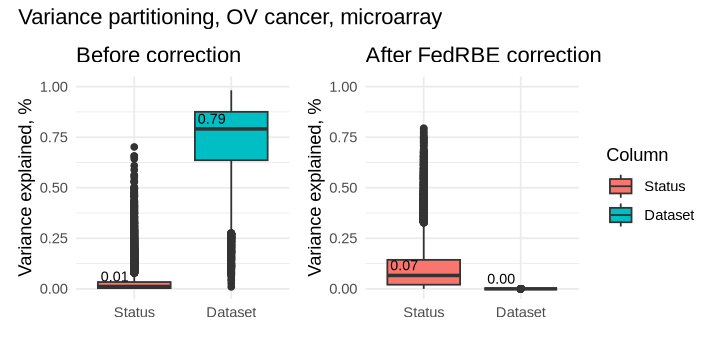

In [33]:
lmpv_plot_uncorrected <- lmpv_plot(central_uncorrected, metadata, 
    title = paste("Before correction"),
    show_legend=F)
# lmpv_plots_corrected <- lmpv_plot(central_corrected, metadata, 
#     title = paste("After central correction"), show_legend=F)
lmpv_plot_fed <- lmpv_plot(fed_corrected, metadata, 
    title = paste("After FedRBE correction"), show_legend=T)


layout <- (lmpv_plot_uncorrected + lmpv_plot_fed)
layout <- layout + plot_annotation("Variance partitioning, OV cancer, microarray")
options(repr.plot.width=6, repr.plot.height=3)
layout

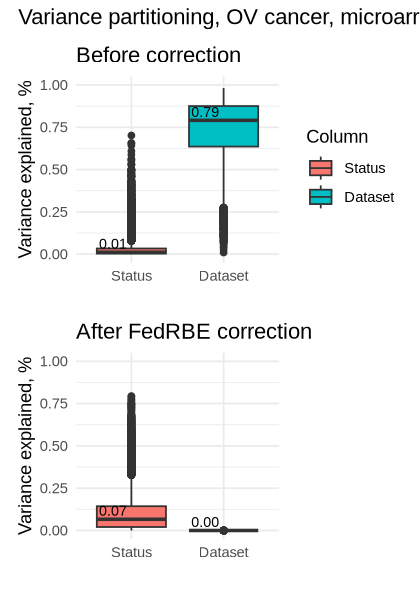

In [35]:
lmpv_plot_uncorrected <- lmpv_plot(central_uncorrected, metadata, 
    title = paste("Before correction"),
    show_legend=T)
lmpv_plot_fed <- lmpv_plot(fed_corrected, metadata, 
    title = paste("After FedRBE correction"), show_legend=F)


layout <- lmpv_plot_uncorrected /
           lmpv_plot_fed
layout <- layout + plot_annotation("Variance partitioning, OV cancer, microarray")
options(repr.plot.width=3.5, repr.plot.height=5)
layout

# Errors

In [ ]:
# calculate differences between central and fedRBE corrected data
# print it as a table
differences <- calculated_differences(central_corrected, fed_corrected)
cat("Min difference:", differences[2], "\n")
cat("Mean difference:", differences[3], "\n")
cat("Max difference:", differences[1], "\n")

Min difference: 0 
Mean difference: 4.015396e-15 
Max difference: 8.171241e-14 


In [ ]:
# Combine the data frames into a single data frame for easy plotting
data <- data.frame(
  Expression = as.vector(rowMeans(central_corrected, na.rm = TRUE)),    # calculate the mean expression for each row
  Error = as.vector(rowMeans(abs(central_corrected - fed_corrected), na.rm = TRUE)),    # calculate the mean absolute difference between the two data sets
  MaxError = as.vector(apply(abs(central_corrected - fed_corrected), 1, max, na.rm = TRUE))    # calculate the maximum absolute difference between the two data sets
)

`geom_smooth()` using formula = 'y ~ x'


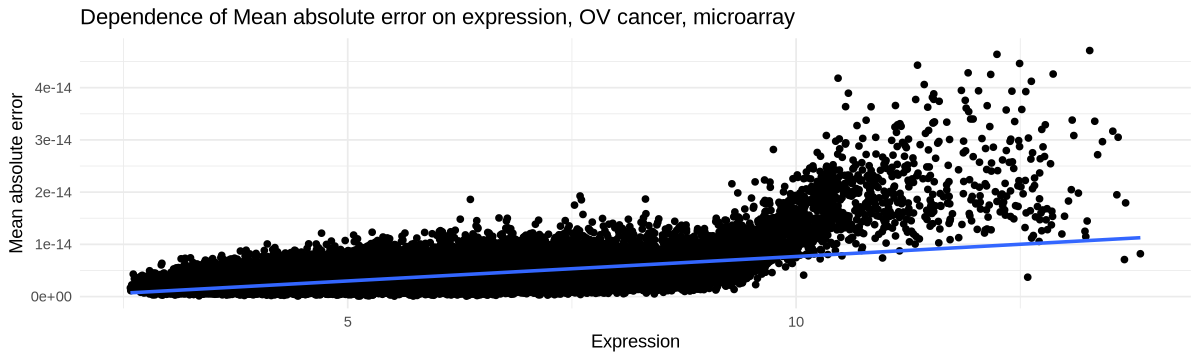

In [ ]:
# Plot the data
ggplot(data, aes(x = Expression, y = Error)) +
  geom_point() +  # Scatter plot of Expression vs. Error
  geom_smooth(method = "lm", se = FALSE) +  # Add a trend line (optional)
  labs(title = "Dependence of Mean absolute error on expression, OV cancer, microarray",
       x = "Expression",
       y = "Mean absolute error") +
  # add y limits from 5e-14 to 5e-15
  #   scale_y_continuous(limits = c(5e-16,5e-13)) +
  theme_minimal() 
  


No id variables; using all as measure variables

No id variables; using all as measure variables



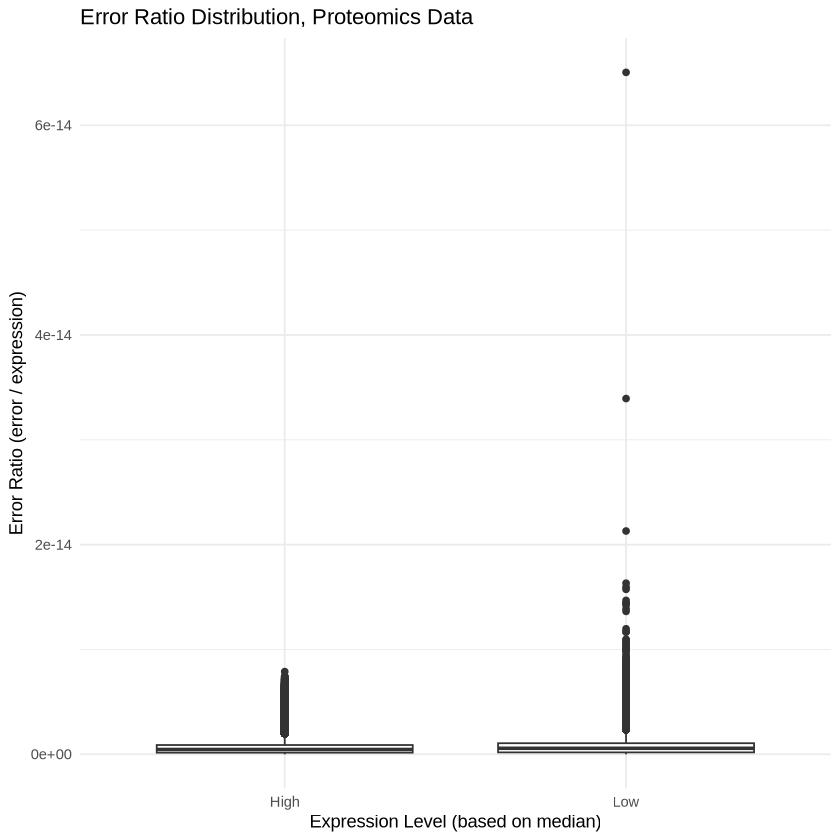

In [5]:
library(reshape2)

# Calculate ratio expression errors (assuming both data frames are of the same dimensions)
ratio_expr_errors <- abs(abs(central_corrected - fed_corrected) / central_corrected)

# Calculate the median expression value across the entire central_corrected dataframe
median_expression <- median(as.matrix(central_corrected), na.rm = TRUE)

# Melt the data frames to convert them to long format
ratio_expr_errors_long <- melt(ratio_expr_errors, varnames = c("Row", "Column"), value.name = "ErrorRatio")
central_corrected_long <- melt(central_corrected, varnames = c("Row", "Column"), value.name = "ExpressionValue")

# Combine the melted data frames
combined_data <- ratio_expr_errors_long
combined_data$ExpressionValue <- central_corrected_long$ExpressionValue
combined_data <- na.omit(combined_data)

# Add a column to determine if each value is 'Low' or 'High' based on the median expression value
combined_data$ExpressionLevel <- ifelse(combined_data$ExpressionValue < median_expression, "Low", "High")

# Plot as two boxplots
ggplot(combined_data, aes(x = ExpressionLevel, y = ErrorRatio)) +
  geom_boxplot() +
  labs(
    title = "Error Ratio Distribution, Proteomics Data",
    x = "Expression Level (based on median)",
    y = "Error Ratio (error / expression)"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5),
    axis.ticks.x = element_blank()
  )